In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import genot

/home/icb/dominik.klein/mambaforge/envs/genot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-20 12:33:48.225156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 12:33:48.670649: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 12:33:48.957769: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 12:34:11.464418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] T

In [3]:
from genot.models.model import GENOT
from genot.nets.nets import MLP_vector_field

In [4]:
import seaborn as sns
import genot
import jax
import ott
import diffrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from genot.nets.nets import MLP_vector_field, MLP_marginal
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from genot.data.data import MixtureNormalSampler
from genot.plotting.plots import plot_1D_unbalanced

In [5]:
source = MixtureNormalSampler(jax.random.PRNGKey(0), [0.0, 2.0], 1,  0.4, weights=[0.5, 0.5], batch_size=1024)
target = MixtureNormalSampler(jax.random.PRNGKey(1), [-1.0,1.0, 5.0], 1,  0.1, batch_size=1024)

In [6]:
epsilon = 5e-2
tau_a = 0.99
tau_b = 0.99

In [7]:
vf = MLP_vector_field(output_dim=1, latent_embed_dim=1024)

In [8]:
ot_solver = ott.solvers.linear.sinkhorn.Sinkhorn()
mlp_eta = MLP_marginal(256, 5)
mlp_xi = MLP_marginal(256, 5)

In [9]:
solver = GENOT(neural_net=vf, 
               input_dim=1, 
               output_dim=1, 
               iterations=10_000, 
               ot_solver = ot_solver, 
               tau_a=tau_a, 
               tau_b=tau_b, 
               epsilon=epsilon,
              mlp_eta=mlp_eta,
              mlp_xi=mlp_xi)

In [10]:
solver(source, target, 1024, 1024)

100%|██████████| 10000/10000 [05:50<00:00, 28.51it/s]


In [11]:
source_batch = next(source)
target_batch = next(target)

rescale_source = solver.state_eta.apply_fn({"params": solver.state_eta.params}, source_batch)
rescale_target = solver.state_xi.apply_fn({"params": solver.state_xi.params}, target_batch)

res, _, _ = solver.transport(source_batch, seed=1, diffeqsolve_kwargs={"max_steps": 1_000_000})

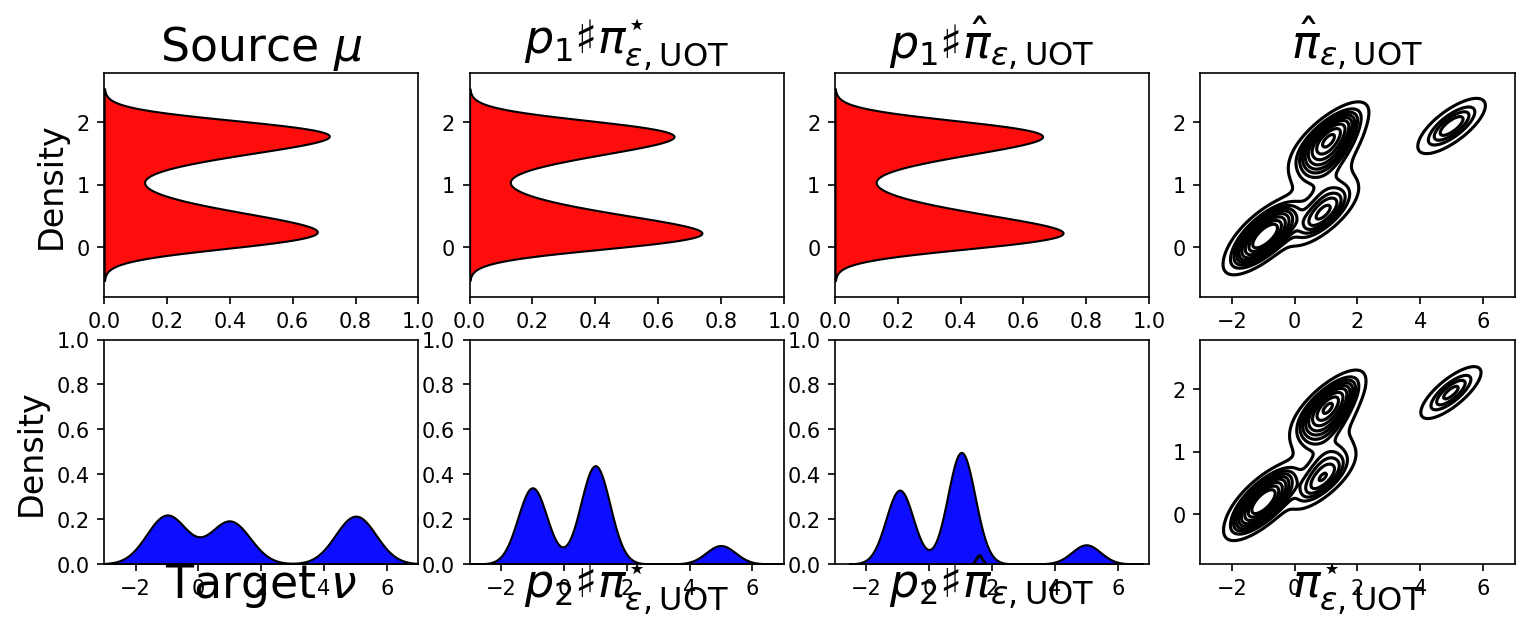

In [12]:
kwargs = {}
a = (-0.8, 2.8) # source support
b = (0.0, 1.0) # density plot
c = (0.0, 4.0)
d = (-3.0, 7.0) # target support
kwargs["00_xlim"] = b
kwargs["01_xlim"] = b
kwargs["02_xlim"] = b
kwargs["03_xlim"] = d
kwargs["10_xlim"] = d
kwargs["11_xlim"] = d
kwargs["12_xlim"] = d
kwargs["13_xlim"] = d

kwargs["00_ylim"] = a
kwargs["01_ylim"] = a
kwargs["02_ylim"] = a
kwargs["03_ylim"] = a
kwargs["10_ylim"] = b
kwargs["11_ylim"] = b
kwargs["12_ylim"] = b
kwargs["13_ylim"] = a



fig = plot_1D_unbalanced(source_batch, target_batch, res[0,...], rescale_source, rescale_target, epsilon=epsilon, tau_a=tau_a, tau_b=tau_b, seed=1, figsize=(10,4), dpi=150, **kwargs)
